<h1 align="center";style="color:blue">Brain Tumor Classifier </h1>

In [28]:
# pip install opencv-python
%pip install opencv-python-headless
%pip install pillow
%pip install tensorflow
%pip install pandas matplotlib pillow


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam,Adamax


In [50]:

## Dataset
no = [r'C:\Users\Vinay\Documents\Physician.Ai\Trained Model\brain tumor\dataset\no']
yes = [r'C:\Users\Vinay\Documents\Physician.Ai\Trained Model\brain tumor\dataset\yes']
file_p = []
labels = []
dict_lists = [no, yes]
class_labels = ['no', 'yes']

for i, dir_list in enumerate(dict_lists):
     for j in dir_list:
            list_f = os.listdir(j)
            for name in list_f:
                fpath = os.path.join(j, name)
                file_p.append(fpath)
                labels.append(class_labels[i])


failpath = pd.Series(file_p, name="filepaths")
Labelss = pd.Series(labels, name="labels")
data = pd.concat([failpath, Labelss], axis=1)
df = pd.DataFrame(data)

In [51]:
df.head()

,filepaths,labels
0,C:\Users\Vinay\Documents\Physician.Ai\Trained ...,no
1,C:\Users\Vinay\Documents\Physician.Ai\Trained ...,no
2,C:\Users\Vinay\Documents\Physician.Ai\Trained ...,no
3,C:\Users\Vinay\Documents\Physician.Ai\Trained ...,no
4,C:\Users\Vinay\Documents\Physician.Ai\Trained ...,no


In [32]:
print(len(label))

3000


In [52]:
## need to conver to numpy array
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42,stratify=df.labels)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42,stratify=train_df.labels)
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(1912, 2)
(750, 2)
(338, 2)


In [53]:
def enhance_image(image):
    image = cv2.addWeighted(image, 1.5, image, -0.5, 0)

    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    image = cv2.filter2D(image, -1, kernel)

    hue = image[:, :, 0]
    saturation = image[:, :, 1]
    value = image[:, :, 2]
    value = np.clip(value * 1.25, 0, 255)

    image[:, :, 2] = value

    return image

In [54]:
image_gen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda image: enhance_image(image))
train = image_gen.flow_from_dataframe(dataframe= train_df,x_col="filepaths",y_col="labels",
                                      target_size=(256,256),
                                      color_mode='rgb',
                                      class_mode="categorical", 
                                      batch_size=64,
                                      shuffle=False            
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_df,x_col="filepaths", y_col="labels",
                                     target_size=(256,256),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=64,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_df,x_col="filepaths", y_col="labels",
                                    target_size=(256,256),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=64,
                                    shuffle=False
                                   )

Found 1912 validated image filenames belonging to 2 classes.
Found 750 validated image filenames belonging to 2 classes.
Found 338 validated image filenames belonging to 2 classes.


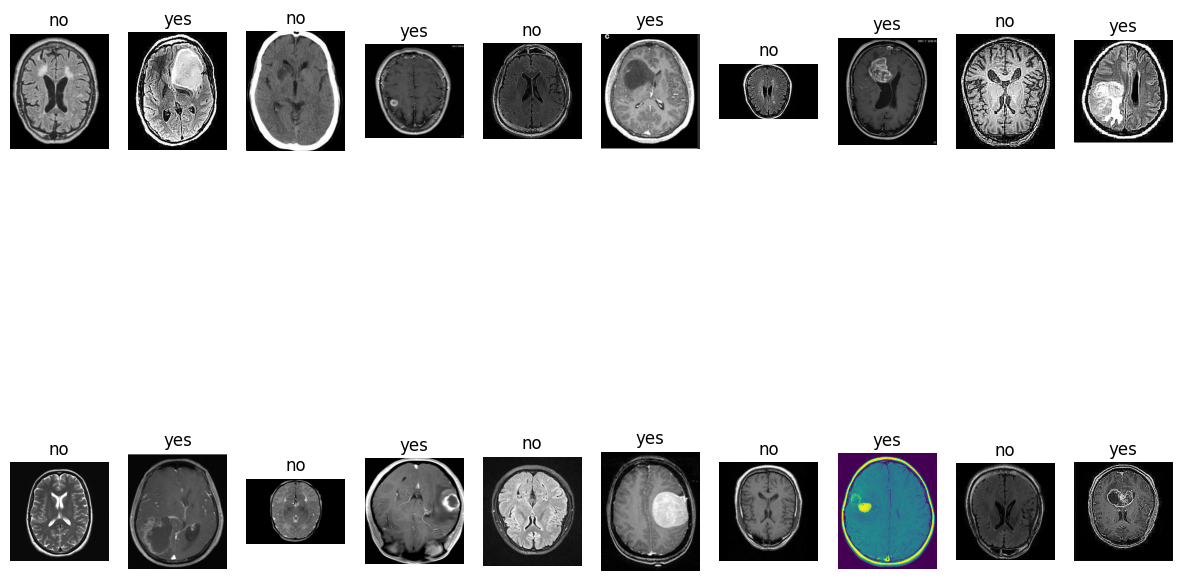

In [55]:
import matplotlib.pyplot as plt

# Define the number of images to display from each class
num_images_per_class = 10

# Get class labels
class_labels = list(train.class_indices.keys())

# Plot images from each class
plt.figure(figsize=(15, 10))
for label in class_labels:
    # Get indices of images belonging to the current class
    indices = train_df[train_df['labels'] == label].index
    
    # Randomly sample a subset of indices if there are more than the desired number of images per class
    indices = np.random.choice(indices, min(num_images_per_class, len(indices)), replace=False)
    
    # Plot images
    for i, idx in enumerate(indices):
        plt.subplot(len(class_labels), num_images_per_class, len(class_labels)*i + class_labels.index(label) + 1)
        plt.imshow(plt.imread(train_df.loc[idx, 'filepaths']))  # Load and plot the image
        plt.title(label)
        plt.axis('off')
plt.show()

In [56]:
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception

learning_rate = 0.001
base_model = Xception(weights='imagenet', include_top=False, pooling='max')
x = base_model.output
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adamax(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10


c:\Users\Vinay\Documents\Physician.Ai\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


AbortedError: Graph execution error:

Detected at node StatefulPartitionedCall/functional_19_1/block11_sepconv3_1/separable_conv2d defined at (most recent call last):
<stack traces unavailable>
Operation received an exception:Status: 1, message: could not create a memory object, in file tensorflow/core/kernels/mkl/mkl_conv_ops.cc:1112
	 [[{{node StatefulPartitionedCall/functional_19_1/block11_sepconv3_1/separable_conv2d}}]] [Op:__inference_one_step_on_iterator_58163]

In [38]:
X_train.max(), X_train.min()

(1.0, 0.0)

In [39]:
## Build The model
model = tf.keras.Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.summary()

c:\Users\Vinay\Documents\Physician.Ai\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 822,337 (3.14 MB)

 Trainable params: 822,337 (3.14 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, 
                    y_train,
                    batch_size=32,
                    epochs=10, 
                    validation_data=(X_test,y_test))

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.6088 - loss: 0.6394 - val_accuracy: 0.6583 - val_loss: 0.5545
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.7105 - loss: 0.4976 - val_accuracy: 0.6850 - val_loss: 0.4805
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.7355 - loss: 0.4466 - val_accuracy: 0.7400 - val_loss: 0.4320
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.7938 - loss: 0.3929 - val_accuracy: 0.7483 - val_loss: 0.4062
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.8340 - loss: 0.3278 - val_accuracy: 0.8183 - val_loss: 0.3826
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.8350 - loss: 0.3118 - val_accuracy: 0.7650 - val_loss: 0.3868
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.8443 - loss: 0.2720 - val_accuracy: 0.8100 - val_loss: 0.4026
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.8572 - loss: 0.2620 - val_accuracy: 0.8267 - v

In [41]:
model.evaluate(X_test, y_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7907 - loss: 0.4017


[0.4061858057975769, 0.7749999761581421]

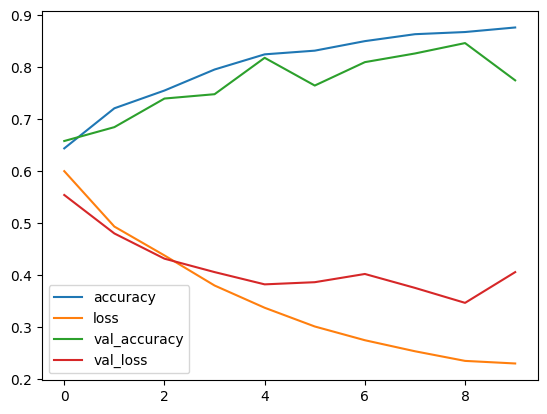

In [42]:
pd.DataFrame(history.history).plot();

In [43]:
# model.save('brain_tumor.h5')
model.save('brain_tumor1.keras')

In [44]:
load_model = load_model('brain_tumor1.keras') 

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [45]:
load_model.evaluate(X_test, y_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7907 - loss: 0.4017


[0.4061858057975769, 0.7749999761581421]

In [46]:
# def img_pred(file_path):
#     rand_img = random.sample(os.listdir(file_path), 1)
# #     print(rand_img)
#     path = file_path + "/" + rand_img[0]
# #     print(path)
#     img = cv2.imread(path)
# #     print(img)
#     img = Image.fromarray(img)
#     img = img.resize((64,64))
#     img = np.array(img)
# #     print(img.shape)
#     img = np.expand_dims(img, axis=0)
# #     print(img.shape)
    
#     result = load_model.predict(img)
#     print(f'image: {rand_img[0]}')
    
# #     display the image
#     pic = mpimg.imread(path)
#     plt.title(f'predicted: {int(result[0][0])}')
#     plt.imshow(pic)


In [47]:
# img_pred('dataset/pred')